In [67]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize

import torch
import torchtext
import torch.nn as nn
from torch.utils import data


import torchtext.data as ttd
from torchtext.vocab import GloVe

from collections import OrderedDict

from datetime import datetime

In [2]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3_000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2_000
LATENT_DIM = 25

SOS = "<sos>"
EOS = "<eos>"

In [3]:
# data path
robert_frost = '../../Lazyprogrammer/seq2seq/robert_frost.txt'

In [4]:
# load in the data 
lines = []
for line in open(robert_frost):
    line = line.lower().rstrip()
    if not line:
        continue
    lines.append(line)
        


print("number of lines :", len(lines))

number of lines : 1436


In [5]:
# looking at some random lines
idx = np.random.randint(len(lines))
print(lines[idx])

and set off briskly for so slow a thing,


In [6]:
# build vocab
voc = []
l = []
#stop_words = stopwords.words("english")

for line in open(robert_frost):
    line = word_tokenize(re.sub("\W+", " ", line.lower())) 
    for w in line:
        if w not in voc: # and w not in stop_words:
            voc.append(w)

voc = voc + [EOS, SOS]

In [7]:
# convert vocabulary to indices and keep the order (OrderedDict)
word2idx = {}
for idx, w in enumerate(reversed(voc)):
    word2idx[w] = idx + 1 # key=word, item=index

word2idx_keys = word2idx.keys()
print("Length of vocab : {0:d} tokens".format(len(word2idx)))

Length of vocab : 2120 tokens


In [8]:
# tokenizing inputs and targets
input_sequences = []
target_sequences = []
for line in lines:
    line = word_tokenize(re.sub("\W+", " ", line.lower())) 
    input_sequence = [word2idx[SOS]] + [word2idx[w] for w in line]
    target_sequence = [word2idx[w] for w in line] + [word2idx[EOS]]
    input_sequences.append(input_sequence)
    target_sequences.append(target_sequence)
    


In [9]:
max_sequence_length = max(len(s) for s in input_sequences)
print("max_sequence_length:", max_sequence_length)

max_sequence_length: 15


In [10]:
# post padding
k = 0
for i in range(len(input_sequences)):
    if len(input_sequences[i]) < max_sequence_length:
        input_sequences[i] += (max_sequence_length - len(input_sequences[i])) * [0]
        target_sequences[i] += (max_sequence_length - len(target_sequences[i])) * [0]

In [12]:
# shape of data
len(input_sequences), len(input_sequences[0])

(1436, 15)

In [13]:
# load in pre-trained word vectors 
# can download here 
# word2vec = torchtext.vocab.GloVe(name="6B", dim=EMBEDDING_DIM) 
print("loading word vectors ...")
word2vec_path = '../../Lazyprogrammer/large_files/glove.6B/glove.6B.%sd.txt'
word2vec = {}
with open(
    os.path.join(word2vec_path % EMBEDDING_DIM)
) as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2]
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.array(values[1:], dtype="float32")
        word2vec[word] = vec
    print("Found %s word vectors." % len(word2vec))

loading word vectors ...
Found 400000 word vectors.


In [14]:
# prepare embedding matrix
print("Filling pre-trained embeddings...")
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < num_words:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [15]:
# one-hot the targets (can't use sparse categorical cross entropy)
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [28]:
num_words

2121

In [27]:
# load pre-trained word embeddings into an embedding layer
# freeze the layer
embedding_layer = nn.Embedding(num_words, EMBEDDING_DIM,)  # vocab size  # embedding dim
embedding_layer.weight = nn.Parameter(torch.from_numpy(embedding_matrix).float())
embedding_layer.requires_grad = False


In [29]:
one_hot_targets.shape

(1436, 15, 2121)

In [31]:
# shape of data
len(input_sequences), len(input_sequences[0])

(1436, 15)

In [ ]:
# N x T x D
# T = 15 
# D = LATENT_DIM
# embedding_layer = nn.Embedding(num_words, EMBEDDING_DIM,) : N x T -> N x T x EMBEDDING_DIM

In [86]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size=EMBEDDING_DIM, hidden_size=LATENT_DIM, num_layers=1, batch_first=True) # -> N x T x LATENT_DIM 
        self.fc1 = nn.Linear(LATENT_DIM, num_words)
    
    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), LATENT_DIM)#.to(device)
        c0 = torch.zeros(1, X.size(0), LATENT_DIM)#.to(device)
        
        out = embedding_layer(X) # N x T x EMBEDDING_DIM
        out, _ = self.rnn(out, (h0, c0)) # N x T x LATENT_DIM
        #out = out[:, -1, :] # N x LATENT_DIM
        out = self.fc1(out) # N x num_words

        return out
        

In [76]:
# transform to tensors
input_sequences = torch.FloatTensor(input_sequences).int()
one_hot_targets = torch.FloatTensor(one_hot_targets)


In [78]:
input_sequences.dtype

torch.int32

In [87]:
# instantiate model
model = RNN()
# model.to(device)

In [88]:
# simple test 
x = torch.ones(2,15, dtype=torch.int) 
y = model(x)
y.shape

torch.Size([2, 15, 2121])

In [89]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [90]:
# make the dataset
class PoetryDataset(data.Dataset):
    def __init__(self):
        pass
    
    def __len__(self):
        return len(input_sequences)

    def __getitem__(self, idx):
        return input_sequences[idx], one_hot_targets[idx]


In [91]:
poetry_dataset = PoetryDataset()

In [92]:
data_loader = torch.utils.data.DataLoader(
    dataset=poetry_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE)

In [93]:
for inputs, targets in data_loader:
    print(inputs.shape)
    print(targets.shape)
    outputs = model(inputs)
    print(outputs.shape)
    break

torch.Size([128, 15])
torch.Size([128, 15, 2121])
torch.Size([128, 15, 2121])


In [94]:
# training loop

# loss to store
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)

for it in range(EPOCHS):

    train_loss = []
    for inputs, targets in data_loader:
        # move data to gpu
        #inputs, targets = inputs.to(device), targets.to(device)
        
        # forward
        outputs = model(inputs)

        # compute loss
        loss = criterion(outputs, targets)

        # zero the grad
        optimizer.zero_grad()

        # backward
        loss.backward()
        optimizer.step()

        # store loss
        train_loss.append(loss.item())
    
    # final loss
    train_loss = np.mean(train_loss)
    train_losses[it] = train_loss


    # prints
    print(f"Epoch {it+1}/{EPOCHS}. Train Loss = {train_loss:.4f}")


Epoch 1/2000. Train Loss = 0.0112
Epoch 2/2000. Train Loss = 0.0112
Epoch 3/2000. Train Loss = 0.0110
Epoch 4/2000. Train Loss = 0.0109
Epoch 5/2000. Train Loss = 0.0107
Epoch 6/2000. Train Loss = 0.0106
Epoch 7/2000. Train Loss = 0.0103
Epoch 8/2000. Train Loss = 0.0100
Epoch 9/2000. Train Loss = 0.0097
Epoch 10/2000. Train Loss = 0.0094
Epoch 11/2000. Train Loss = 0.0092
Epoch 12/2000. Train Loss = 0.0091
Epoch 13/2000. Train Loss = 0.0089
Epoch 14/2000. Train Loss = 0.0088
Epoch 15/2000. Train Loss = 0.0086
Epoch 16/2000. Train Loss = 0.0086
Epoch 17/2000. Train Loss = 0.0085
Epoch 18/2000. Train Loss = 0.0083
Epoch 19/2000. Train Loss = 0.0083
Epoch 20/2000. Train Loss = 0.0082
Epoch 21/2000. Train Loss = 0.0081
Epoch 22/2000. Train Loss = 0.0080
Epoch 23/2000. Train Loss = 0.0080
Epoch 24/2000. Train Loss = 0.0078
Epoch 25/2000. Train Loss = 0.0078
Epoch 26/2000. Train Loss = 0.0077
Epoch 27/2000. Train Loss = 0.0076
Epoch 28/2000. Train Loss = 0.0075
Epoch 29/2000. Train Loss = 0

Epoch 232/2000. Train Loss = 0.0032
Epoch 233/2000. Train Loss = 0.0031
Epoch 234/2000. Train Loss = 0.0031
Epoch 235/2000. Train Loss = 0.0031
Epoch 236/2000. Train Loss = 0.0031
Epoch 237/2000. Train Loss = 0.0031
Epoch 238/2000. Train Loss = 0.0031
Epoch 239/2000. Train Loss = 0.0031
Epoch 240/2000. Train Loss = 0.0031
Epoch 241/2000. Train Loss = 0.0031
Epoch 242/2000. Train Loss = 0.0031
Epoch 243/2000. Train Loss = 0.0031
Epoch 244/2000. Train Loss = 0.0031
Epoch 245/2000. Train Loss = 0.0030
Epoch 246/2000. Train Loss = 0.0031
Epoch 247/2000. Train Loss = 0.0030
Epoch 248/2000. Train Loss = 0.0030
Epoch 249/2000. Train Loss = 0.0030
Epoch 250/2000. Train Loss = 0.0030
Epoch 251/2000. Train Loss = 0.0030
Epoch 252/2000. Train Loss = 0.0030
Epoch 253/2000. Train Loss = 0.0030
Epoch 254/2000. Train Loss = 0.0030
Epoch 255/2000. Train Loss = 0.0030
Epoch 256/2000. Train Loss = 0.0030
Epoch 257/2000. Train Loss = 0.0030
Epoch 258/2000. Train Loss = 0.0030
Epoch 259/2000. Train Loss =

Epoch 460/2000. Train Loss = 0.0019
Epoch 461/2000. Train Loss = 0.0020
Epoch 462/2000. Train Loss = 0.0020
Epoch 463/2000. Train Loss = 0.0019
Epoch 464/2000. Train Loss = 0.0019
Epoch 465/2000. Train Loss = 0.0019
Epoch 466/2000. Train Loss = 0.0019
Epoch 467/2000. Train Loss = 0.0019
Epoch 468/2000. Train Loss = 0.0019
Epoch 469/2000. Train Loss = 0.0019
Epoch 470/2000. Train Loss = 0.0019
Epoch 471/2000. Train Loss = 0.0019
Epoch 472/2000. Train Loss = 0.0019
Epoch 473/2000. Train Loss = 0.0019
Epoch 474/2000. Train Loss = 0.0019
Epoch 475/2000. Train Loss = 0.0019
Epoch 476/2000. Train Loss = 0.0019
Epoch 477/2000. Train Loss = 0.0019
Epoch 478/2000. Train Loss = 0.0019
Epoch 479/2000. Train Loss = 0.0019
Epoch 480/2000. Train Loss = 0.0019
Epoch 481/2000. Train Loss = 0.0019
Epoch 482/2000. Train Loss = 0.0019
Epoch 483/2000. Train Loss = 0.0019
Epoch 484/2000. Train Loss = 0.0019
Epoch 485/2000. Train Loss = 0.0018
Epoch 486/2000. Train Loss = 0.0018
Epoch 487/2000. Train Loss =

Epoch 688/2000. Train Loss = 0.0013
Epoch 689/2000. Train Loss = 0.0014
Epoch 690/2000. Train Loss = 0.0014
Epoch 691/2000. Train Loss = 0.0014
Epoch 692/2000. Train Loss = 0.0014
Epoch 693/2000. Train Loss = 0.0014
Epoch 694/2000. Train Loss = 0.0014
Epoch 695/2000. Train Loss = 0.0013
Epoch 696/2000. Train Loss = 0.0014
Epoch 697/2000. Train Loss = 0.0013
Epoch 698/2000. Train Loss = 0.0014
Epoch 699/2000. Train Loss = 0.0014
Epoch 700/2000. Train Loss = 0.0013
Epoch 701/2000. Train Loss = 0.0013
Epoch 702/2000. Train Loss = 0.0013
Epoch 703/2000. Train Loss = 0.0014
Epoch 704/2000. Train Loss = 0.0014
Epoch 705/2000. Train Loss = 0.0013
Epoch 706/2000. Train Loss = 0.0013
Epoch 707/2000. Train Loss = 0.0014
Epoch 708/2000. Train Loss = 0.0013
Epoch 709/2000. Train Loss = 0.0013
Epoch 710/2000. Train Loss = 0.0013
Epoch 711/2000. Train Loss = 0.0013
Epoch 712/2000. Train Loss = 0.0013
Epoch 713/2000. Train Loss = 0.0013
Epoch 714/2000. Train Loss = 0.0013
Epoch 715/2000. Train Loss =

Epoch 916/2000. Train Loss = 0.0010
Epoch 917/2000. Train Loss = 0.0010
Epoch 918/2000. Train Loss = 0.0010
Epoch 919/2000. Train Loss = 0.0010
Epoch 920/2000. Train Loss = 0.0010
Epoch 921/2000. Train Loss = 0.0010
Epoch 922/2000. Train Loss = 0.0010
Epoch 923/2000. Train Loss = 0.0010
Epoch 924/2000. Train Loss = 0.0010
Epoch 925/2000. Train Loss = 0.0010
Epoch 926/2000. Train Loss = 0.0010
Epoch 927/2000. Train Loss = 0.0010
Epoch 928/2000. Train Loss = 0.0010
Epoch 929/2000. Train Loss = 0.0010
Epoch 930/2000. Train Loss = 0.0010
Epoch 931/2000. Train Loss = 0.0010
Epoch 932/2000. Train Loss = 0.0010
Epoch 933/2000. Train Loss = 0.0010
Epoch 934/2000. Train Loss = 0.0010
Epoch 935/2000. Train Loss = 0.0010
Epoch 936/2000. Train Loss = 0.0010
Epoch 937/2000. Train Loss = 0.0010
Epoch 938/2000. Train Loss = 0.0010
Epoch 939/2000. Train Loss = 0.0010
Epoch 940/2000. Train Loss = 0.0010
Epoch 941/2000. Train Loss = 0.0010
Epoch 942/2000. Train Loss = 0.0010
Epoch 943/2000. Train Loss =

Epoch 1140/2000. Train Loss = 0.0008
Epoch 1141/2000. Train Loss = 0.0008
Epoch 1142/2000. Train Loss = 0.0008
Epoch 1143/2000. Train Loss = 0.0008
Epoch 1144/2000. Train Loss = 0.0008
Epoch 1145/2000. Train Loss = 0.0008
Epoch 1146/2000. Train Loss = 0.0008
Epoch 1147/2000. Train Loss = 0.0008
Epoch 1148/2000. Train Loss = 0.0008
Epoch 1149/2000. Train Loss = 0.0008
Epoch 1150/2000. Train Loss = 0.0008
Epoch 1151/2000. Train Loss = 0.0008
Epoch 1152/2000. Train Loss = 0.0008
Epoch 1153/2000. Train Loss = 0.0008
Epoch 1154/2000. Train Loss = 0.0008
Epoch 1155/2000. Train Loss = 0.0008
Epoch 1156/2000. Train Loss = 0.0008
Epoch 1157/2000. Train Loss = 0.0008
Epoch 1158/2000. Train Loss = 0.0008
Epoch 1159/2000. Train Loss = 0.0008
Epoch 1160/2000. Train Loss = 0.0008
Epoch 1161/2000. Train Loss = 0.0008
Epoch 1162/2000. Train Loss = 0.0008
Epoch 1163/2000. Train Loss = 0.0008
Epoch 1164/2000. Train Loss = 0.0008
Epoch 1165/2000. Train Loss = 0.0008
Epoch 1166/2000. Train Loss = 0.0008
E

Epoch 1362/2000. Train Loss = 0.0007
Epoch 1363/2000. Train Loss = 0.0007
Epoch 1364/2000. Train Loss = 0.0007
Epoch 1365/2000. Train Loss = 0.0007
Epoch 1366/2000. Train Loss = 0.0006
Epoch 1367/2000. Train Loss = 0.0006
Epoch 1368/2000. Train Loss = 0.0006
Epoch 1369/2000. Train Loss = 0.0006
Epoch 1370/2000. Train Loss = 0.0006
Epoch 1371/2000. Train Loss = 0.0006
Epoch 1372/2000. Train Loss = 0.0006
Epoch 1373/2000. Train Loss = 0.0006
Epoch 1374/2000. Train Loss = 0.0006
Epoch 1375/2000. Train Loss = 0.0006
Epoch 1376/2000. Train Loss = 0.0006
Epoch 1377/2000. Train Loss = 0.0006
Epoch 1378/2000. Train Loss = 0.0006
Epoch 1379/2000. Train Loss = 0.0006
Epoch 1380/2000. Train Loss = 0.0006
Epoch 1381/2000. Train Loss = 0.0006
Epoch 1382/2000. Train Loss = 0.0007
Epoch 1383/2000. Train Loss = 0.0006
Epoch 1384/2000. Train Loss = 0.0006
Epoch 1385/2000. Train Loss = 0.0006
Epoch 1386/2000. Train Loss = 0.0006
Epoch 1387/2000. Train Loss = 0.0006
Epoch 1388/2000. Train Loss = 0.0006
E

Epoch 1584/2000. Train Loss = 0.0006
Epoch 1585/2000. Train Loss = 0.0006
Epoch 1586/2000. Train Loss = 0.0006
Epoch 1587/2000. Train Loss = 0.0005
Epoch 1588/2000. Train Loss = 0.0005
Epoch 1589/2000. Train Loss = 0.0005
Epoch 1590/2000. Train Loss = 0.0005
Epoch 1591/2000. Train Loss = 0.0005
Epoch 1592/2000. Train Loss = 0.0005
Epoch 1593/2000. Train Loss = 0.0005
Epoch 1594/2000. Train Loss = 0.0005
Epoch 1595/2000. Train Loss = 0.0005
Epoch 1596/2000. Train Loss = 0.0005
Epoch 1597/2000. Train Loss = 0.0005
Epoch 1598/2000. Train Loss = 0.0005
Epoch 1599/2000. Train Loss = 0.0005
Epoch 1600/2000. Train Loss = 0.0005
Epoch 1601/2000. Train Loss = 0.0005
Epoch 1602/2000. Train Loss = 0.0005
Epoch 1603/2000. Train Loss = 0.0005
Epoch 1604/2000. Train Loss = 0.0005
Epoch 1605/2000. Train Loss = 0.0005
Epoch 1606/2000. Train Loss = 0.0005
Epoch 1607/2000. Train Loss = 0.0005
Epoch 1608/2000. Train Loss = 0.0005
Epoch 1609/2000. Train Loss = 0.0005
Epoch 1610/2000. Train Loss = 0.0005
E

Epoch 1806/2000. Train Loss = 0.0005
Epoch 1807/2000. Train Loss = 0.0004
Epoch 1808/2000. Train Loss = 0.0004
Epoch 1809/2000. Train Loss = 0.0004
Epoch 1810/2000. Train Loss = 0.0004
Epoch 1811/2000. Train Loss = 0.0004
Epoch 1812/2000. Train Loss = 0.0004
Epoch 1813/2000. Train Loss = 0.0004
Epoch 1814/2000. Train Loss = 0.0004
Epoch 1815/2000. Train Loss = 0.0004
Epoch 1816/2000. Train Loss = 0.0004
Epoch 1817/2000. Train Loss = 0.0004
Epoch 1818/2000. Train Loss = 0.0005
Epoch 1819/2000. Train Loss = 0.0004
Epoch 1820/2000. Train Loss = 0.0004
Epoch 1821/2000. Train Loss = 0.0004
Epoch 1822/2000. Train Loss = 0.0004
Epoch 1823/2000. Train Loss = 0.0004
Epoch 1824/2000. Train Loss = 0.0004
Epoch 1825/2000. Train Loss = 0.0005
Epoch 1826/2000. Train Loss = 0.0004
Epoch 1827/2000. Train Loss = 0.0004
Epoch 1828/2000. Train Loss = 0.0004
Epoch 1829/2000. Train Loss = 0.0004
Epoch 1830/2000. Train Loss = 0.0004
Epoch 1831/2000. Train Loss = 0.0004
Epoch 1832/2000. Train Loss = 0.0004
E

In [100]:
torch.save(model, './poetry.pth')

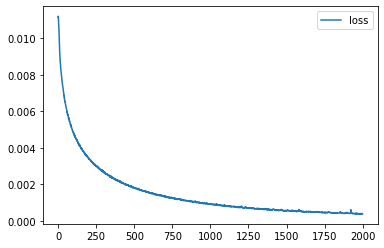

In [96]:
# plot some data
plt.plot(train_losses, label="loss")
plt.legend()
plt.show()

In [103]:
# making a sampling model
class SamplingModel(nn.Module):
    def __init__(self):
        super(SamplingModel, self).__init__()
        self.rnn = nn.LSTM(input_size=EMBEDDING_DIM, hidden_size=LATENT_DIM, num_layers=1, batch_first=True) # -> N x T x LATENT_DIM 
        self.fc1 = nn.Linear(LATENT_DIM, num_words)
    
    def forward(self, X, h, c):
        #h0 = torch.zeros(1, X.size(0), LATENT_DIM)#.to(device)
        #c0 = torch.zeros(1, X.size(0), LATENT_DIM)#.to(device)
        
        # we only predict one word at a time
        out = embedding_layer(X) # 1 x T x EMBEDDING_DIM
        out, (h, c) = model.rnn(out, (h, c)) # 1 x T x LATENT_DIM
        out = model.fc1(out) # 1 x T x num_words

        return out, h, c
        

In [104]:
sampling_model = SamplingModel()

In [107]:
# simple test 
x = torch.ones(2,15, dtype=torch.int) 
h0 = torch.zeros(1, x.size(0), LATENT_DIM)#.to(device)
c0 = torch.zeros(1, x.size(0), LATENT_DIM)#.to(device)
y, h, c = sampling_model(x, h0, c0)
y.shape, h.shape, c.shape

(torch.Size([2, 15, 2121]), torch.Size([1, 2, 25]), torch.Size([1, 2, 25]))

In [116]:
y.shape

torch.Size([2, 15, 2121])

In [108]:
# reverse word2idx dictionnay to get back words
# during prediction
idx2word = {v: w for w, v in word2idx.items()}

In [125]:
# used for sampling function
softmax = nn.Softmax(dim=2)

In [153]:
def sample_line():    
    # initial inputs
    np_input = torch.tensor([[word2idx["<sos>"]]]).int()
    h = torch.zeros(1, 1, LATENT_DIM)
    c = torch.zeros(1, 1, LATENT_DIM)

    # so we know when to quit
    eos_idx = word2idx["<eos>"]

    # store the ouput sentence here
    output_sentence = []

    for _ in range(max_sequence_length):
        o, h, c = sampling_model(np_input, h, c)


        #print("o.shape", o.shape, o[0, 0, :5])

        probs = softmax(o).view(-1)

        idx = np.random.choice(len(probs), p=probs.detach().numpy())
        if idx == eos_idx:
            break

        # accumulate output
        output_sentence.append(idx2word.get(idx))

        # make the next input into model
        np_input[0, 0] = idx
    return " ".join(output_sentence)

In [ ]:
# generate a 4 line poem
while True:
    for _ in range(4):
        print(sample_line())

    ans = input("---generate another? [Y/n]----")
    if ans and ans[0].lower().startswith('n'):
        break

strangely the garden door other when
drawn far of her any
theirs for the wrong wrong three
wherever far the earth or other herself
---generate another? [Y/n]----y
saturn o been done up
estelle then the ever
huh their little long went must
estelle then have the a night
---generate another? [Y/n]----y
proclaimed with sound of her
incredulous the garden door other
besides the sound again three
proclaimed our other again three
---generate another? [Y/n]----y
studying want have them the man
because set far family himself when when were
incredulous their in the open
thence whose if have strange himself away
